# Rendu Regression Quantile
>__Auteurs__:   ABOUQATEB Mouad, CADON Mathilde, LEYE ElHadji 

Commençons par importer les packages  nécessaires pour l'implémentation de la regression quantile.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from download import download
import statsmodels.formula.api as ols
import time
import cvxpy as cp
import statsmodels.api as sm
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.linear_model import RidgeCV, Ridge
import ipywidgets as ip
import os
import sys
sys.path.append("./codes")

plt.rcParams.update({'figure.max_open_warning': 25})  #

# Traitement  des données

Dans cette partie nous nous sommes  inspirés  du travail de nos camarades Joly Julien , Mohamed Sahardid et Anas El Benna

In [2]:
url = "http://josephsalmon.eu/enseignement/datasets/Mesure_journaliere_Region_Occitanie_Polluants_Principaux.csv"
path_target = "datasets/Mesure_journaliere_Region_Occitanie_Polluants_Principaux.csv"
download(url, path_target, replace=True)

file_sizes:   0%|                                   | 0.00/5.59M [00:00<?, ?B/s]

file_sizes: 100%|██████████████████████████| 5.59M/5.59M [00:04<00:00, 1.33MB/s]

Successfully downloaded file to datasets/Mesure_journaliere_Region_Occitanie_Polluants_Principaux.csv


'datasets/Mesure_journaliere_Region_Occitanie_Polluants_Principaux.csv'

In [3]:
occ_raw = pd.read_csv(path_target)
occ_raw['date'] = pd.to_datetime(occ_raw['date_debut']).dt.to_period('M')

occ = occ_raw.dropna()
occ.describe()

/home/jo/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


,X,Y,id,code_insee,id_poll_ue,valeur_originale,x_l93,y_l93,x_wgs84,y_wgs84,FID
count,20808.000000,20808.000000,20808.000000,20808.000000,20808.000000,20808.000000,20808.000000,2.080800e+04,20808.000000,20808.000000,20808.000000
mean,2.294313,43.571370,10404.500000,39870.082612,833.119906,33.823889,642723.199923,6.276022e+06,2.294313,43.571370,10404.500000
std,1.445291,0.317169,6006.896536,17521.409462,2065.511158,28.775214,116870.515281,3.490882e+04,1.445291,0.317169,6006.896536
min,-0.051944,42.684000,1.000000,9225.000000,1.000000,-1.000000,451389.000000,6.176050e+06,-0.051944,42.684000,1.000000
25%,1.418610,43.556900,5202.750000,31069.000000,5.000000,10.100000,572227.000000,6.274400e+06,1.418610,43.556900,5202.750000
50%,1.622590,43.610600,10404.500000,31555.000000,7.000000,20.167708,587812.000000,6.279360e+06,1.622590,43.610600,10404.500000
75%,3.886890,43.695400,15606.250000,34255.000000,7.000000,59.000000,771643.000000,6.288810e+06,3.886890,43.695400,15606.250000
max,4.697360,44.466500,20808.000000,81065.000000,6001.000000,143.498962,836001.000000,6.375360e+06,4.697360,44.466500,20808.000000


Maintenant que nos données sont récupérées nous créons une liste "ville" où l'utilisateur indique les villes qu'il veut étudier. Remarquons que la commande isin() permet de vérifier l'existence de ces villes dans nos données. 
Nous définissons comme date le mois de juillet 2018 de manière arbitraire et nous allont regarder les relevés d'ozone.

In [4]:
ville = 'MONTPELLIER', 'TOULOUSE', 'AGDE'

df = occ[occ['nom_com'].isin(ville)]
df = df[df['polluant'] == 'O3']

df.date.unique()

df = df[df.date == '2018-07']
df = df[['nom_com', 'valeur_originale']]

Nous récupérons ensuite sous forme d'array les relevés d'ozone des villes choisies ainsi que leur nombre (car les villes n'ont pas forcément le même nombre d'observations) puis nous recodons ensuite nos villes en variables qualitatives de manière à pouvoir effectuer notre régression quantile.

In [5]:
valeur_o3 = []
len_villes = []

for i in range(len(ville)):

    o3_i = df[df['nom_com'] == ville[i]].values[:, 1]

    # valeurs de O3 des villes choisies
    valeur_o3 = np.append(valeur_o3, o3_i)

    # Nombre d'observations de chaque ville
    len_villes = np.append(len_villes, o3_i.shape)

X = np.zeros((int(np.sum(len_villes)), len(ville)))

for i in range(len(ville)):
    X[int(np.sum(len_villes[0:i])):int(np.sum(len_villes[0:i + 1])
                                       ), i] = np.ones(
                                           int(np.sum(len_villes[i])))

#  La regression quantile

Dans la regression classique, des moindres carrés ordinaire, nous cherchons à miniser la somme quadratique des déviations:
$$\text{argmin}_{\beta} \sum (\beta ^Tx_i- y_i)^2 $$

Nous avons vu qu'une variante de ce problème est d'ajouter un biais de régularisation (Ridge):
$$\text{argmin}_{\beta} \sum (\beta ^Tx_i- y_i)^2  + \lambda \|\beta \|_2^2,$$  

Dans la régression quantile, le problème d'optimisation dépendra du quantile $\alpha$ désiré, le problème d'optimisation se reformule sous:
$$\text{argmin}_{\beta} \sum l_{\alpha}(\beta ^Tx_i- y_i)$$
     
Avec:
$$l_{\alpha}: u \rightarrow \alpha (u)_+ + (1-\alpha) (u)_- = (1/2)|u| + (\alpha-1/2) u  \quad    \text{    (la perte 'flipper')}$$


## Implémentation de la  régression quantile en utilisant le package CVXPY


Commençons par definir les valeurs du quantile $\alpha$. Nous n'avons pas pris en compte les valeurs limites (0 et 1) car ces dernières ne permettent pas d'avoir un résultat stable.

In [6]:
tol = 0.001
alpha_vals = np.linspace(0 + tol, 1 - tol, 100)

### Implémentation du problème d'optimisation

In [7]:
Y = valeur_o3
X = X

w = cp.Variable(X.shape[1])
alpha = cp.Parameter()

error = 0

for i in range(len(X)):
    r = Y[i] - (w.T * X[i])
    error += 0.5 * cp.abs(r) + (alpha - 0.5) * r

prob = cp.Problem(cp.Minimize(error))

### Implémentation de la résolution du problème d'optimisation

In [8]:
r_vals = np.zeros((len(alpha_vals), len(X)))

pred = np.zeros((len(alpha_vals), len(X)))
start1 = time.time()
for k, alpha_val in enumerate(alpha_vals):
    alpha.value = alpha_val
    prob.solve(solver=cp.ECOS)

    for i in range(len(X)):
        pred[k, i] = (X[i].T * w).value
        r_vals[k, i] = (Y[i] - (X[i].T * w)).value
end1 = time.time()
t1 = end1 - start1
np.unique(pred, axis=1)

array([[ 48.83378642,  51.19999133,  61.20207221],
       [ 48.83379368,  51.20002584,  61.2020808 ],
       [ 48.83379699,  52.20000005,  61.202084  ],
       [ 48.83379804,  52.80000005,  61.20208508],
       [ 54.83784888,  53.39999999,  68.18923188],
       [ 54.83784901,  54.80000007,  68.18923196],
       [ 54.83785056,  55.2999997 ,  68.18923366],
       [ 57.9239578 ,  55.39999921,  70.00833097],
       [ 57.923958  ,  56.19999991,  70.008331  ],
       [ 57.92395818,  56.29999982,  70.00833125],
       [ 58.917362  ,  56.29999996,  70.38854177],
       [ 58.91736212,  56.30000432,  70.38854203],
       [ 58.91736211,  58.40000002,  70.38854201],
       [ 59.35833294,  58.40000085,  71.23471686],
       [ 59.35833392,  58.50000021,  71.23471785],
       [ 59.35833411,  59.09999978,  71.23471804],
       [ 61.27916677,  59.59999994,  72.49999931],
       [ 61.279167  ,  59.899999  ,  72.49999989],
       [ 61.27916707,  59.90000001,  72.5000001 ],
       [ 61.27916724,  59.90000

#  Implémentation de la  régression quantile en utilisant le package  statsmodels.

In [26]:
start2 = time.time()
mod = ols.quantreg('valeur_originale~nom_com', df)

# prediction : lignes:les quantiles; colonnes:les trois villes
nCol = len(np.unique(df[['nom_com']]))
nRow = len(alpha_vals)
prediction = np.zeros((nRow, nCol))

for k, alpha in enumerate(alpha_vals):
    res = mod.fit(q=alpha)
    # les trois quantiles sans redandances
    prediction[k] = (np.unique(res.predict(df[['nom_com']])))

end2 = time.time()
t2 = end2 - start2

In [10]:
print(
    "le temps d'excution avec l'implémentation de la régression quantile en utilisant CVXPY :",
    t1)
print(
    "le temps d'excution avec l'implémentation obtenue par celle du package statsmodels.:",
    t2)

le temps d'excution avec l'implémentation de la régression quantile en utilisant CVXPY : 72.46638202667236
le temps d'excution avec l'implémentation obtenue par celle du package statsmodels.: 5.587733268737793


On note que l'implémentation avec le package statsmodels est environ dix fois plus performante que l'implémentation réalisée "à la main" en utilisant le package CVXPY.

# Comparaison entre la régression Ridge et la régression quantile

Nous réalisons tout d'abord le même graphique que le groupe précédent en affichant, cette fois, les valeurs de nos régressions quantile en fonction du paramètre $\alpha$

In [11]:
def quantile_comparaison(alpha):
    np.random.seed(44)
    current_palette = sns.color_palette()
    fig = sns.catplot(y="valeur_originale",
                      x="nom_com",
                      data=df,
                      jitter='0.05',
                      legend_out=False,
                      order=list(ville),
                      height=8)

    plt.axhline(y=np.mean(valeur_o3),
                xmin=0,
                xmax=len(ville),
                ls='--',
                linewidth=3,
                color='grey')
    plt.text(len(ville) - 0.3,
             np.mean(valeur_o3) - 2,
             '$\\bar y$',
             color='grey',
             verticalalignment='bottom',
             horizontalalignment='right',
             fontsize=25)

    mod = ols.quantreg('valeur_originale~nom_com', df)
    nCol = len(np.unique(df[['nom_com']]))
    nRow = 1
    prediction = np.zeros((nRow, nCol))

    res = mod.fit(q=alpha)
    # les trois quantiles sans redondances
    prediction = (np.unique(res.predict(df[['nom_com']])))

    for i in range(len(ville)):
        plt.scatter(i,
                    np.mean(valeur_o3[int(np.sum(len_villes[0:i])
                                          ):int(np.sum(len_villes[0:i + 1]))]),
                    marker='_',
                    lw=10,
                    color=current_palette[i],
                    s=600)

        plt.text(i + 0.2,
                 np.mean(valeur_o3[int(np.sum(len_villes[0:i])
                                       ):int(np.sum(len_villes[0:i + 1]))] -
                         2),
                 '$\\bar y _{}$'.format(i),
                 verticalalignment='bottom',
                 horizontalalignment='left',
                 color=current_palette[i],
                 fontsize=20)

        plt.scatter(i,
                    prediction[i],
                    s=400,
                    marker='_',
                    color=current_palette[i],
                    lw=3,
                    label='Regression Quantile {}'.format(ville[i]))

    plt.legend(loc='upper left', bbox_to_anchor=(1., .9))
    plt.tight_layout()
    plt.title('Regression quantile en fonction du quantile choisi')

In [12]:
%matplotlib inline
ip.interact(quantile_comparaison, alpha=(0.0001, 0.9999, 0.001))

interactive(children=(FloatSlider(value=0.4991, description='alpha', max=0.9999, min=0.0001, step=0.001), Outp…

<function __main__.quantile_comparaison(alpha)>

Remarquons que pour  $\alpha=0.5$  notre régression retourne la médiane des observations, l'estimateur (OLS) (Ridge  𝜆=0 ) retourne la moyenne des observations, ce qui explique les résultats presques similaires pour ces valeurs.

De plus, on remarque que pour la régression quantile, la prédiction couvre toutes les valeurs en fonction du quantile choisi alors que pour la prédiction Ridge, les prédictions sont toujours proches de la moyenne.

Vérifions maintenant les valeurs obtenues par la régression quantile pour des variables catégorielles.

In [13]:
def quantile(alpha):
    np.random.seed(44)
    current_palette = sns.color_palette()
    fig = sns.catplot(y="valeur_originale",
                      x="nom_com",
                      data=df,
                      jitter='0.05',
                      legend_out=False,
                      order=list(ville),
                      height=8)
    ax = sns.boxplot(x="nom_com",
                     y="valeur_originale",
                     data=df,
                     order=["MONTPELLIER", "TOULOUSE", "AGDE"],
                     boxprops=dict(alpha=.3))

    mod = ols.quantreg('valeur_originale~nom_com', df)
    nCol = len(np.unique(df[['nom_com']]))
    nRow = 1
    prediction = np.zeros((nRow, nCol))

    res = mod.fit(q=alpha)
    # les trois quantiles sans redondance
    prediction = (np.unique(res.predict(df[['nom_com']])))

    for i in range(len(ville)):
        plt.scatter(i,
                    prediction[i],
                    s=400,
                    marker='_',
                    color=current_palette[i],
                    lw=5,
                    label='Regression Quantile {}'.format(ville[i]))

    plt.legend(loc='upper left', bbox_to_anchor=(1., .9))
    plt.tight_layout()
    plt.title('Regression quantile en fonction du quantile choisi')

In [14]:
%matplotlib inline
ip.interact(quantile, alpha=(0.0001, 0.9999, 0.01))

interactive(children=(FloatSlider(value=0.4901, description='alpha', max=0.9999, min=0.0001, step=0.01), Outpu…

<function __main__.quantile(alpha)>

Avec ce graphe, on à la vérification visuelle des valeurs des quantiles selon le boxplot des villes. On remarque donc bien que l'on retrouve la médiane et les quantiles 0.25 et 0.75 (un peu biaisés).

Lorsque l'on a $\alpha=0.5$ cela signifie que la distance à $\mu$ est nulle et on retrouve bien la médiane.

# Reproduction de la figure du livre

Importons les bibliothéques nécessaires à la réalisation de cette figure

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp
from ipywidgets import interact

In [16]:
data = pd.DataFrame({
    "Location": ["Quito", "Cape of Good Hope", "Rome", "Paris", "Lapland"],
    "Latitude": [0.0, 33.18, 42.59, 49.23, 66.19],
    "sin2(Latitude)": [0, 0.2987, 0.4648, 0.5762, 0.8386],
    "Arc Length": [56751, 57037, 56979, 57074, 57422],
    "Arc Length of 1 Degree of Latitude": [
        56751 - 56700, 57037 - 56700, 56979 - 56700, 57074 - 56700,
        57422 - 56700
    ]
})

In [17]:
data

,Location,Latitude,sin2(Latitude),Arc Length,Arc Length of 1 Degree of Latitude
0,Quito,0.00,0.0000,56751,51
1,Cape of Good Hope,33.18,0.2987,57037,337
2,Rome,42.59,0.4648,56979,279
3,Paris,49.23,0.5762,57074,374
4,Lapland,66.19,0.8386,57422,722


Nous avons ensuite fait la regression quantile grâce au package CVXPY.

On cherche à prédire les valeurs de notre "Arc Length of 1 Degree of Latitude"

In [18]:
# Definition du problème
X = data["sin2(Latitude)"]
Y = data["Arc Length of 1 Degree of Latitude"]

B = cp.Variable()  # Notre $\beta$ à estimer
B0 = cp.Variable()  # Ce paramêtre correspond à notre constante dans le modèle
tau = cp.Parameter()
error = 0
for i in range(len(X)):
    r = Y[i] - (B.T * X[i] + B0)
    error += 0.5 * cp.abs(r) + (tau - 0.5) * r  # fonction à minimiser
prob = cp.Problem(cp.Minimize(error))

Nous venons de définir le problème en lui indiquant la fonction à minimiser. Cette fonction est la fonction de la regression quantile avec la norme $L_{1}$.

Nous avons pris des valeurs du quantile comprises entre 0 et 1 (nos $\tau$). Les points extrèmes 0 ou 1 ne nous donne pas les bons résultats vu que ce sont des valeurs extrèmes. Nous avons donc ajouter une tolérance pour notre calcul.

In [19]:
tol = 0.001
N = 1000
# Nous testons 1000 valeurs de quantile
tau_vals = np.linspace(0 + tol, 1 - tol, N)
pred = np.zeros((len(tau_vals), len(X)))  # Notre matrice de prédiction
r_vals = np.zeros((len(tau_vals), len(X)))
for k, tau_val in enumerate(tau_vals):
    tau.value = tau_val
    prob.solve()
    for i in range(len(X)):
        pred[k, i] = (X[i].T * B + B0).value
        r_vals[k, i] = (Y[i] - (X[i].T * B + B0)).value

On vient de réussir à obtenir nos prédictions dans la matrice "pred".

On remarque qu'il y à plusieurs valeurs de $\beta$ qui sont identiques pour des $\tau$ différents.
Nous cherchons donc à retrouver ces différentes valeurs et à partir de quel moments elles changent.

In [21]:
# Pour retourner les indices des quantiles où la valeur change
indice = np.zeros(4)
# On arrondis les valeurs de nos beta pour pouvoir les traiter
A = np.around(pred, decimals=0)

for i in range(1, 4):  # On observe qu'il y a 4 valeurs différentes
    indice[i] = np.where(
        A[int(indice[i - 1]):] != A[int(indice[i - 1])])[0][0] + indice[i - 1]

print(indice)

[0. 1. 2. 3.]


Maintenant que l'on à récupéré les indices nous allons récupérer les valeurs des quantiles associés.

In [22]:
intervals = tau_vals[indice.astype(int)]
print(intervals)

[0.001    0.001999 0.002998 0.003997]


Revenons maintenant à la figure du livre. On observe qu'il y a 4 intervalles. 

Nous venons de retrouver les mêmes intervalles que ceux du livre :

$]0;0.21] ; [0.21;0.48] ; [0.48;0.73] ; [0.73;1[$


Reproduisons maintenant la figure.

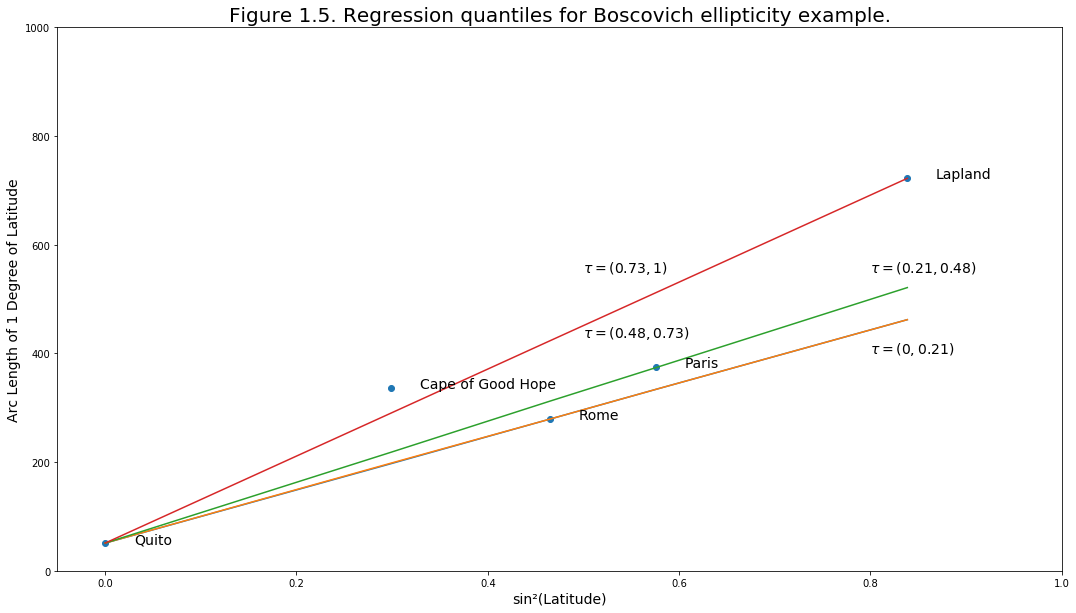

In [30]:
# Permet de stocker nos 4 regressions différentes
droites = np.unique(np.around(pred, decimals=0), axis=0)
fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(X, droites[0])
plt.plot(X, droites[1])
plt.plot(X, droites[2])
plt.plot(X, droites[3])
plt.xlim(-0.05, 1)
plt.ylim(0, 1000)
plt.title(
    "Figure 1.5. Regression quantiles for Boscovich ellipticity example.", fontsize=20)
plt.xlabel("sin²(Latitude)", fontsize=14)
plt.ylabel("Arc Length of 1 Degree of Latitude", fontsize=14)

plt.text(0.8, 400, r"$\tau =(0,0.21)$", fontsize=14)
plt.text(0.8, 550, r"$\tau =(0.21,0.48)$", fontsize=14)
plt.text(0.5, 430, r"$\tau =(0.48,0.73)$", fontsize=14)
plt.text(0.5, 550, r"$\tau =(0.73,1)$", fontsize=14)

ax.scatter(X, Y)

for i, txt in enumerate(data["Location"]):
    ax.annotate(txt, (X[i], Y[i]), xytext=(X[i] + .03, Y[i] - 0.01), fontsize=14)

fig.savefig('fig.pdf')
plt.show()

Nous voulons maintenant avoir une méthode interactive en fonction du paramêtre du quantile.

In [24]:
def reg_quantile1(tau_inter):
    fig, ax = plt.subplots(figsize=(18, 10))
    if 0 <= tau_inter and tau_inter <= intervals[1]:
        plt.plot(X, droites[0], alpha=1, color="black")
        plt.plot(X, droites[1], alpha=0.2, color="black")
        plt.plot(X, droites[2], alpha=0.2, color="black")
        plt.plot(X, droites[3], alpha=0.2, color="black")
    elif intervals[1] < tau_inter and tau_inter <= intervals[2]:
        plt.plot(X, droites[0], alpha=0.2, color="black")
        plt.plot(X, droites[1], alpha=1, color="black")
        plt.plot(X, droites[2], alpha=0.2, color="black")
        plt.plot(X, droites[3], alpha=0.2, color="black")
    elif intervals[2] < tau_inter and tau_inter <= intervals[3]:
        plt.plot(X, droites[0], alpha=0.2, color="black")
        plt.plot(X, droites[1], alpha=0.2, color="black")
        plt.plot(X, droites[2], alpha=1, color="black")
        plt.plot(X, droites[3], alpha=0.2, color="black")
    elif intervals[3] < tau_inter and tau_inter <= 1:
        plt.plot(X, droites[0], alpha=0.2, color="black")
        plt.plot(X, droites[1], alpha=0.2, color="black")
        plt.plot(X, droites[2], alpha=0.2, color="black")
        plt.plot(X, droites[3], alpha=1, color="black")
    plt.xlim(-0.05, 1)
    plt.ylim(0, 1000)
    plt.title(
        "Figure 1.5. Regression quantiles for Boscovich ellipticity example.")
    plt.xlabel("sin²(Latitude)")
    plt.ylabel("Arc Length of 1 Degree of Latitude")

    plt.text(0.8, 400, r"$\tau =(0,0.21)$")
    plt.text(0.8, 550, r"$\tau =(0.21,0.48)$")
    plt.text(0.5, 430, r"$\tau =(0.48,0.73)$")
    plt.text(0.5, 550, r"$\tau =(0.73,1)$")

    ax.scatter(X, Y)

    for i, txt in enumerate(data["Location"]):
        ax.annotate(txt, (X[i], Y[i]), xytext=(X[i] + .03, Y[i] - 0.01))

    plt.show()

In [25]:
interact(reg_quantile1, tau_inter=(0.001, 0.999, 0.01))

interactive(children=(FloatSlider(value=0.491, description='tau_inter', max=0.999, min=0.001, step=0.01), Outp…

<function __main__.reg_quantile1(tau_inter)>

Nous avons affiché les différentes droites de regression en fonction de la valeur de quantile que l'on veut. La droite la plus foncée est celle correspondant à la valeur du quantile que l'on recherche.